# Arima

In this notebook we perform ARIMA on processed Bixi bike history data.

Required imports:

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Imports for time series

In [2]:
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

## Loading the Time-Series Data

Load the bixi trip history data and combine it into a single Pandas DataFrame.


In [3]:
station_bike_demand = pd.read_csv('data/mr_bike_demand.csv', index_col='start_date', parse_dates=['start_date']).asfreq('D')
display(station_bike_demand.head())

,trip_count
start_date,
2014-04-15,31
2014-04-16,67
2014-04-17,140
2014-04-18,108
2014-04-19,128


In [4]:
#infer the frequency of the data
station_bike_demand = station_bike_demand.asfreq(pd.infer_freq(station_bike_demand.index))

### Time frame:
Selecting data from the opening in 2014 to the end of 2019

In [37]:
start_date = datetime(2014, 1, 1)
end_date = datetime(2019, 10, 31)
lim_station_bike_demand = station_bike_demand[start_date:end_date]
display(lim_station_bike_demand)

,trip_count
start_date,
2014-04-15,31
2014-04-16,67
2014-04-17,140
2014-04-18,108
2014-04-19,128
2014-04-20,90
2014-04-21,123
2014-04-22,97
2014-04-23,148


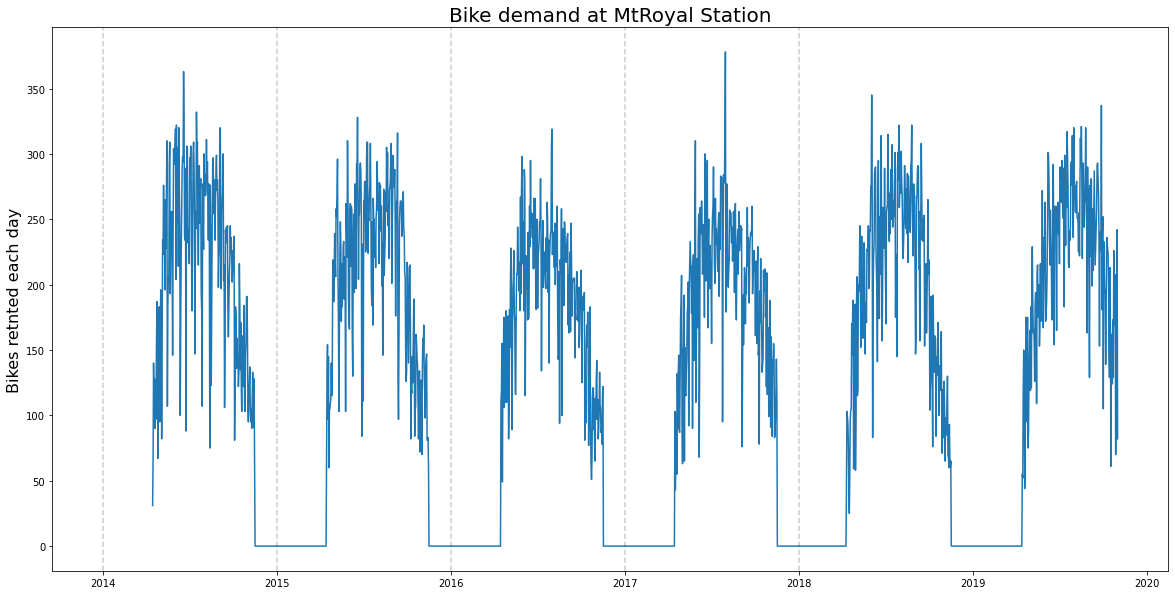

In [38]:
plt.figure(figsize=(20,10))
plt.plot(lim_station_bike_demand)
plt.title('Bike demand at MtRoyal Station', fontsize=20)
plt.ylabel('Bikes retnted each day', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [39]:
first_diff = lim_station_bike_demand.diff()[1:]

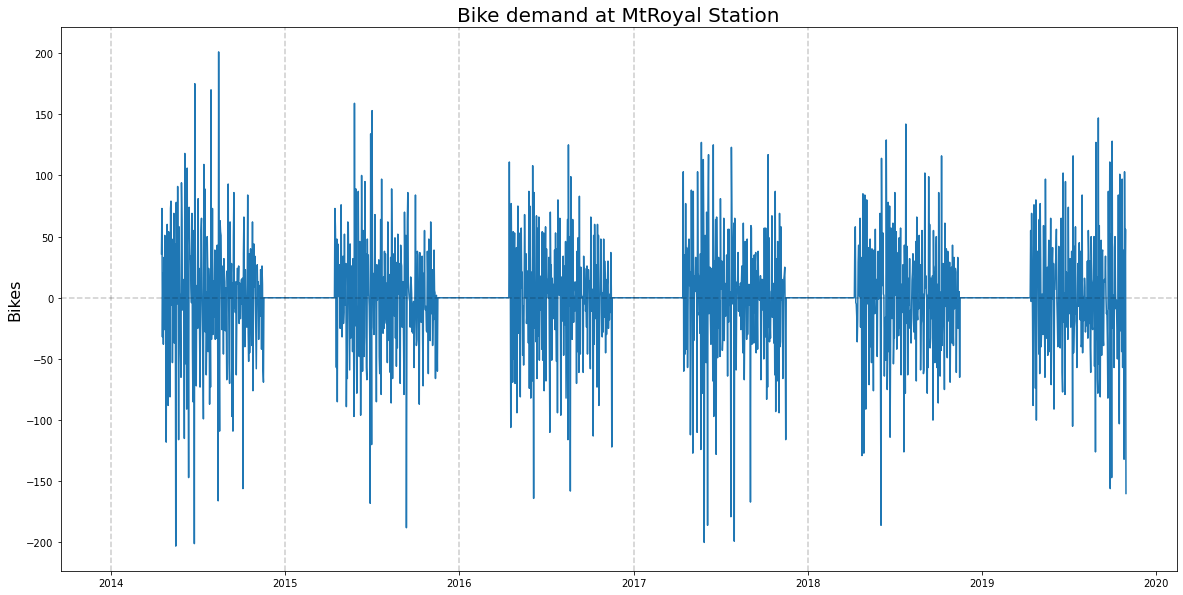

In [40]:
plt.figure(figsize=(20, 10))
plt.plot(first_diff)
plt.title('Bike demand at MtRoyal Station', fontsize=20)
plt.ylabel('Bikes', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2);

## ACF

/Users/hugo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


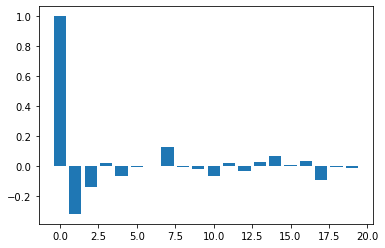

In [41]:
acf_vals = acf(first_diff, fft = False)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags]);

## PACF

/Users/hugo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1022: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


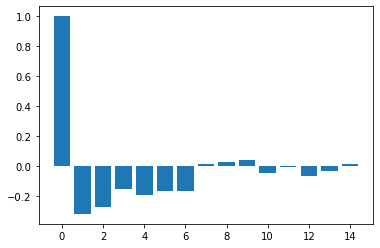

In [42]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags]);

## Get training and testing sets

In [46]:
# Train Data
train_end = datetime(2018, 11, 15)
train_data = lim_station_bike_demand[:train_end]

# Test Data
test_begin = datetime(2019, 4, 14)
test_end = datetime(2019, 10, 31)
test_data = lim_station_bike_demand[test_begin:test_end]
#display(train_data)
# test_data = lim_station_bike_demand[train_end + timedelta(days=1):test_end] #original

#### Plotting training data

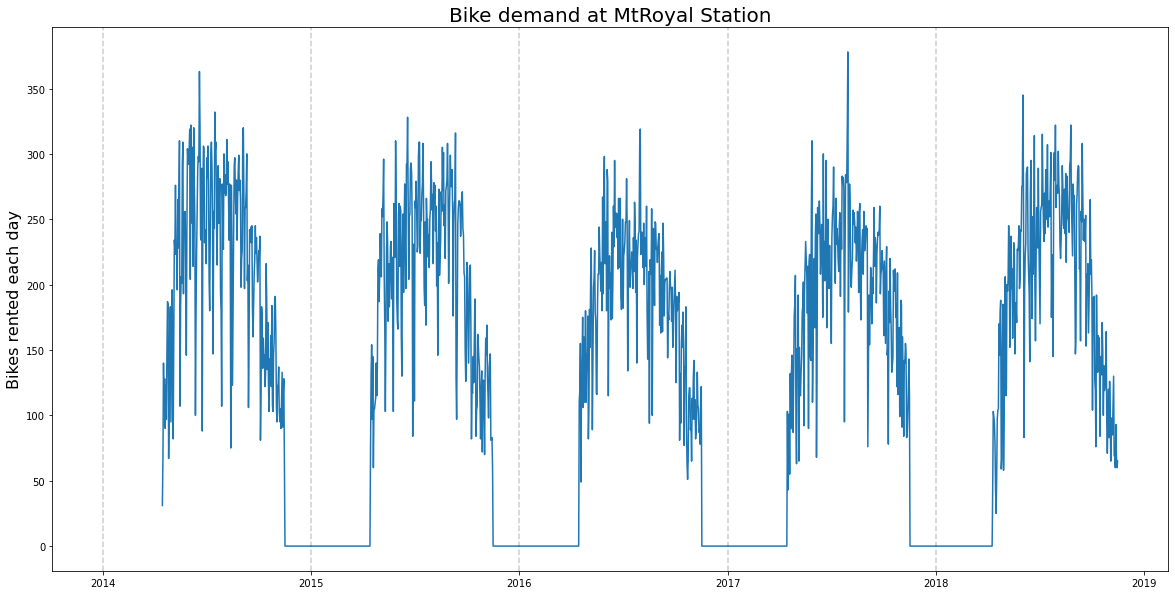

In [47]:
plt.figure(figsize=(20,10))
plt.plot(train_data)
plt.title('Bike demand at MtRoyal Station', fontsize=20)
plt.ylabel('Bikes rented each day', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

#### Plotting testing data

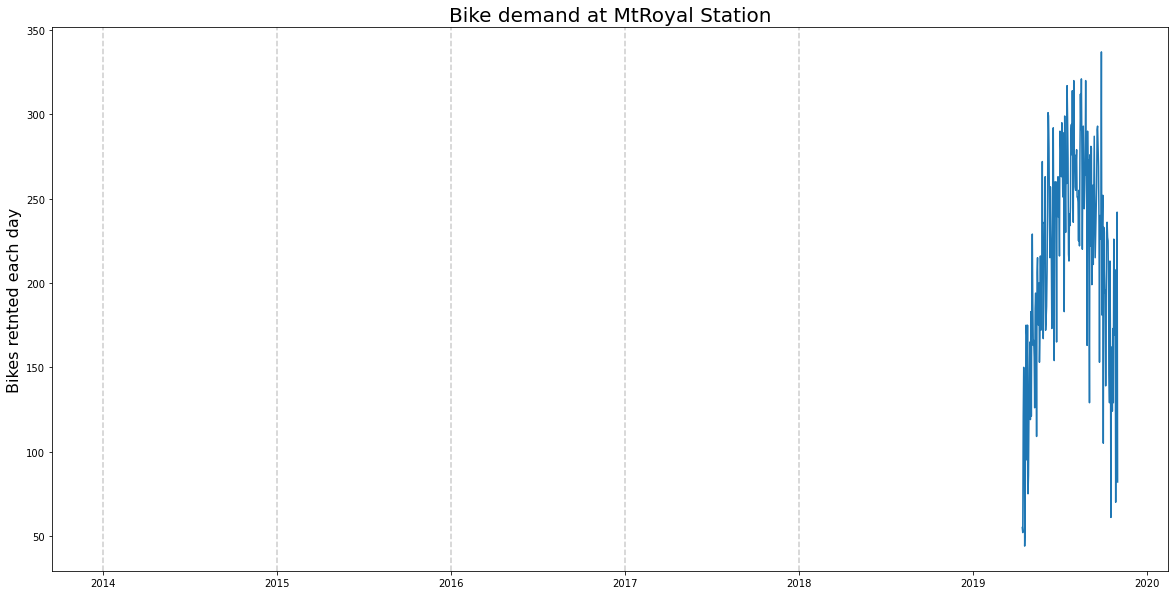

In [13]:
plt.figure(figsize=(20, 10))
plt.plot(test_data)
plt.title('Bike demand at MtRoyal Station', fontsize=20)
plt.ylabel('Bikes retnted each day', fontsize=16)
for year in range(start_date.year, end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Fit the SARIMA Model -------------------------- NEEDS TO BE FIXED

In [50]:
# SARIMA PARAMETERS:

# (p,d,q) # default is (1, 0, 0)

my_order = (0, 1, 0) # ---------------------------- PLS FIX

# PDQS where 

# P
# D
# Q

s = 365 # Seasonality
my_seasonal_order = (1, 0, 1, s) # ------------- PLS FIX

In [22]:
# Defining model
model = SARIMAX(train_data, order = my_order, seasonal_order = my_seasonal_order)

In [23]:
# Fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 388.85000801086426


In [24]:
# Summary of the model
print(model_fit.summary())

                                       SARIMAX Results                                       
Dep. Variable:                            trip_count   No. Observations:                 1676
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 365)   Log Likelihood               -8626.412
Date:                               Fri, 26 Nov 2021   AIC                          17258.824
Time:                                       01:36:39   BIC                          17275.094
Sample:                                   04-15-2014   HQIC                         17264.852
                                        - 11-15-2018                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L365     -0.6759      0.437     -1.546      0.122      -1.533       0.181
ma.S.L365  

### Predictions

In [55]:
# Get predictions and residuals
predictions = model_fit.forecast(len(test_data))
print("len(test_data)): "+str(len(test_data)))
print("len(test_data.index): "+str(len(test_data.index)))

predictions = pd.Series(predictions, index=test_data.index)
pd.set_option('display.max_rows', None)
display(predictions)

len(test_data)): 201
len(test_data.index):201


start_date
2019-04-14    65.950757
2019-04-15    63.391462
2019-04-16    64.917660
2019-04-17    66.620774
2019-04-18    64.737917
2019-04-19    68.664719
2019-04-20    66.605316
2019-04-21    70.693933
2019-04-22    67.664580
2019-04-23    69.945589
2019-04-24    70.503571
2019-04-25    65.015009
2019-04-26    65.332170
2019-04-27    65.454004
2019-04-28    67.268948
2019-04-29    61.027260
2019-04-30    66.879372
2019-05-01    69.192829
2019-05-02    68.079136
2019-05-03    65.479318
2019-05-04    63.817493
2019-05-05    72.448411
2019-05-06    69.983859
2019-05-07    70.240088
2019-05-08    71.028861
2019-05-09    71.297073
2019-05-10    69.849027
2019-05-11    70.342386
2019-05-12    71.304687
2019-05-13    68.335084
2019-05-14    72.544374
2019-05-15    65.311298
2019-05-16    66.449662
2019-05-17    69.270068
2019-05-18    69.456961
2019-05-19    67.325880
2019-05-20    70.504080
2019-05-21    68.479266
2019-05-22    71.306821
2019-05-23    69.982249
2019-05-24    71.587862
2019-

### Residuals:

In [56]:
residuals = test_data - predictions
display(residuals)


,2019-04-14 00:00:00,2019-04-15 00:00:00,2019-04-16 00:00:00,2019-04-17 00:00:00,2019-04-18 00:00:00,2019-04-19 00:00:00,2019-04-20 00:00:00,2019-04-21 00:00:00,2019-04-22 00:00:00,2019-04-23 00:00:00,...,2019-10-23 00:00:00,2019-10-24 00:00:00,2019-10-25 00:00:00,2019-10-26 00:00:00,2019-10-27 00:00:00,2019-10-28 00:00:00,2019-10-29 00:00:00,2019-10-30 00:00:00,2019-10-31 00:00:00,trip_count
start_date,,,,,,,,,,,,,,,,,,,,,
2019-04-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


            2019-04-14 00:00:00  2019-04-15 00:00:00  2019-04-16 00:00:00  \
start_date                                                                  
2019-04-14                  NaN                  NaN                  NaN   
2019-04-15                  NaN                  NaN                  NaN   
2019-04-16                  NaN                  NaN                  NaN   
2019-04-17                  NaN                  NaN                  NaN   
2019-04-18                  NaN                  NaN                  NaN   
2019-04-19                  NaN                  NaN                  NaN   
2019-04-20                  NaN                  NaN                  NaN   
2019-04-21                  NaN                  NaN                  NaN   
2019-04-22                  NaN                  NaN                  NaN   
2019-04-23                  NaN                  NaN                  NaN   
2019-04-24                  NaN                  NaN                  NaN   

### Plot prediction:

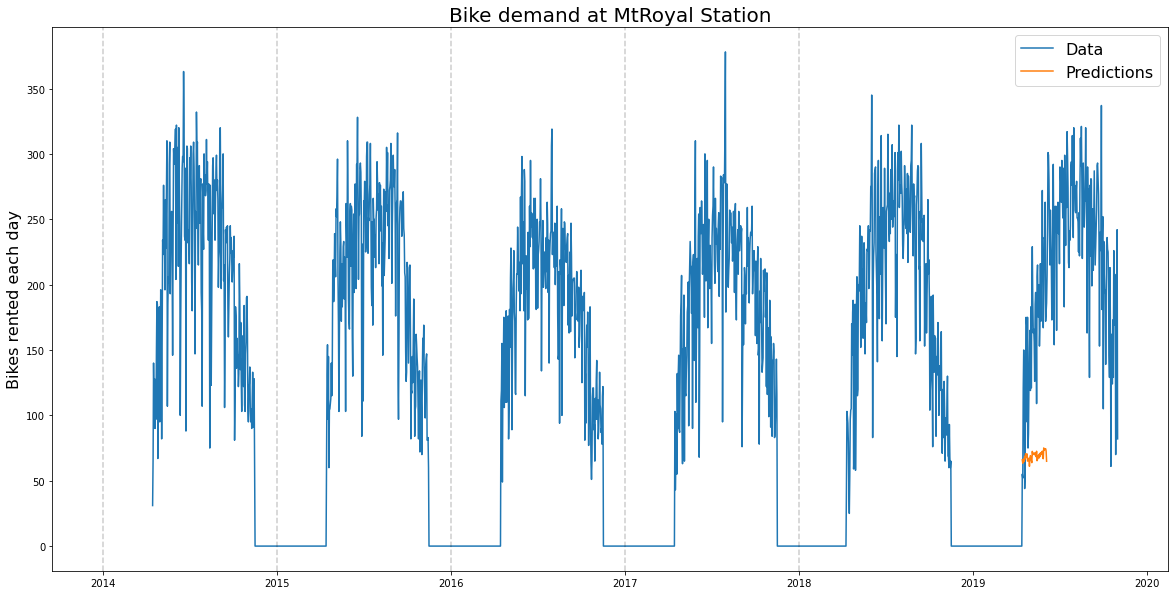

In [27]:
plt.figure(figsize=(20, 10))

plt.plot(lim_station_bike_demand)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Bike demand at MtRoyal Station', fontsize=20)
plt.ylabel('Bikes rented each day', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)